<a href="https://colab.research.google.com/github/arfaluvess/cardio_prediction/blob/main/cardio_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Define the problem and determine the appropriate type of model for the task 

* (e.g. supervised, unsupervised, reinforcement learning).
* Data - Cardiovascular disease [cardio.csv]


In [ ]:
# pip install --upgrade pandas_profiling==3.0.0

In [ ]:
# Get data to be still formated and readable
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Import dependencies
import math
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


mpl.rcParams['figure.figsize'] = (15,12)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameters tuning
from sklearn.model_selection import GridSearchCV

### Collect and preprocess the data

* Load the dataset
* Directly identify the features (X) and (y)
* Identify a categorical and continuos data

In [ ]:
# Load the data
df = pd.read_csv('/content/cardio_train.csv', sep=';')
df.head(3)

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1

In [ ]:
# Renaming columns name with new names
df.rename(columns={'ap_hi':'systolic', 
                   'ap_lo':'diastolic', 
                   'gluc':'glucose',
                   'alco':'alcohol',
                   'cardio':'cardiovascular disease'}, inplace=True)

In [ ]:
duplicate_sum = df.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Dataset contains no Duplicate Values


In [ ]:
# Drop id column as it not effect anything
df.drop('id', axis=1, inplace=True)

# Drop duplicates row
df.drop_duplicates(inplace=True)

# Add column for BMI
df["bmi"] = (df["weight"] / (df["height"]/100)**2).round(1)

# Transform age from days to years
df.age = np.round(df.age/365.25, decimals=1)

# Transform gender from 1, 2 to 1, 0
df.gender = df.gender.replace(2,0)

In [ ]:
df.shape

(69976, 13)

In [ ]:
# To check for data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69976 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     69976 non-null  float64
 1   gender                  69976 non-null  int64  
 2   height                  69976 non-null  int64  
 3   weight                  69976 non-null  float64
 4   systolic                69976 non-null  int64  
 5   diastolic               69976 non-null  int64  
 6   cholesterol             69976 non-null  int64  
 7   glucose                 69976 non-null  int64  
 8   smoke                   69976 non-null  int64  
 9   alcohol                 69976 non-null  int64  
 10  active                  69976 non-null  int64  
 11  cardiovascular disease  69976 non-null  int64  
 12  bmi                     69976 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 7.5 MB


In [ ]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.describe(include='all').T

count        mean         std    min    25%    50%  \
age                     69976.0   53.303143    6.755462   29.6   48.4   53.9   
gender                  69976.0    0.650352    0.476862    0.0    0.0    1.0   
height                  69976.0  164.359152    8.211218   55.0  159.0  165.0   
weight                  69976.0   74.208519   14.397211   10.0   65.0   72.0   
systolic                69976.0  128.820453  154.037729 -150.0  120.0  120.0   
diastolic               69976.0   96.636261  188.504581  -70.0   80.0   80.0   
cholesterol             69976.0    1.366997    0.680333    1.0    1.0    1.0   
glucose                 69976.0    1.226535    0.572353    1.0    1.0    1.0   
smoke                   69976.0    0.088159    0.283528    0.0    0.0    0.0   
alcohol                 69976.0    0.053790    0.225604    0.0    0.0    0.0   
active                  69976.0    0.803718    0.397187    0.0    1.0    1.0   
cardiovascular disease  69976.0    0.499771    0.500004    0.0    0.0    0.0   
bmi                     69976.0   27.556408    6.093296    3.5   23.9   26.4   

                          75%      max  
age                      58.4     64.9  
gender                    1.0      1.0  
height                  170.0    250.0  
weight                   82.0    200.0  
systolic                140.0  16020.0  
diastolic                90.0  11000.0  
cholesterol               2.0      3.0  
glucose                   1.0      3.0  
smoke                     0.0      1.0  
alcohol                   0.0      1.0  
active                    1.0      1.0  
cardiovascular disease    1.0      1.0  
bmi                      30.2    298.7

In [ ]:
# Divide into continuous and categorical data
cat = []
con = []

# Iterate through the columns of the dataframe
for col in df.columns:
  # Check the data type of the column
  if (df[col].dtype in ['float64', 'int64']):
    if df[col].nunique() > 10:
      con.append(col)
    else:
      cat.append(col)
  else:
    cat.append(col)

# Print continuous and categorical columns
print(f'Continuous columns: {con}')
print(f'Categorical columns: {cat}')

Continuous columns: ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi']
Categorical columns: ['gender', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'cardiovascular disease']


In [ ]:
df[con].describe()

age        height        weight      systolic     diastolic  \
count  69976.000000  69976.000000  69976.000000  69976.000000  69976.000000   
mean      53.303143    164.359152     74.208519    128.820453     96.636261   
std        6.755462      8.211218     14.397211    154.037729    188.504581   
min       29.600000     55.000000     10.000000   -150.000000    -70.000000   
25%       48.400000    159.000000     65.000000    120.000000     80.000000   
50%       53.900000    165.000000     72.000000    120.000000     80.000000   
75%       58.400000    170.000000     82.000000    140.000000     90.000000   
max       64.900000    250.000000    200.000000  16020.000000  11000.000000   

                bmi  
count  69976.000000  
mean      27.556408  
std        6.093296  
min        3.500000  
25%       23.900000  
50%       26.400000  
75%       30.200000  
max      298.700000

# Observation

From the above result, we can predict that something is fishy with the data. 

* How can height and blood pressure min max seems faulty

* What does it mean? - An **outliers**
  <br> * An outlier can cause serious problems in stastical analyses and prediction.
  <br> * There are ways to detect outliers:
       1. Using Scatter plot
       2. Using Z-Test
       3. Using IQR Interquartile range
       4. Box plot
  <br> Some outliers are linked to some important features that we dont want to lose. 

# BOX PLOT

In [ ]:
fig = go.Figure()

fig = go.Figure()

# Iterate through the columns of interest
for col in ['height', 'weight', 'bmi']:
  fig.add_trace(go.Box(x=df[col], name = col, boxpoints='outliers'))

fig.update_layout(title_text='Box plot for weight and height with outliers')
fig.show()

In [ ]:
# Make reliable or seems possible of the data 
df = df[(df['height']<230) & (df['weight'] > 20.0)]

In [ ]:
df.count()

age                       69973
gender                    69973
height                    69973
weight                    69973
systolic                  69973
diastolic                 69973
cholesterol               69973
glucose                   69973
smoke                     69973
alcohol                   69973
active                    69973
cardiovascular disease    69973
bmi                       69973
dtype: int64

In [ ]:
df.isnull().sum()

age                       0
gender                    0
height                    0
weight                    0
systolic                  0
diastolic                 0
cholesterol               0
glucose                   0
smoke                     0
alcohol                   0
active                    0
cardiovascular disease    0
bmi                       0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



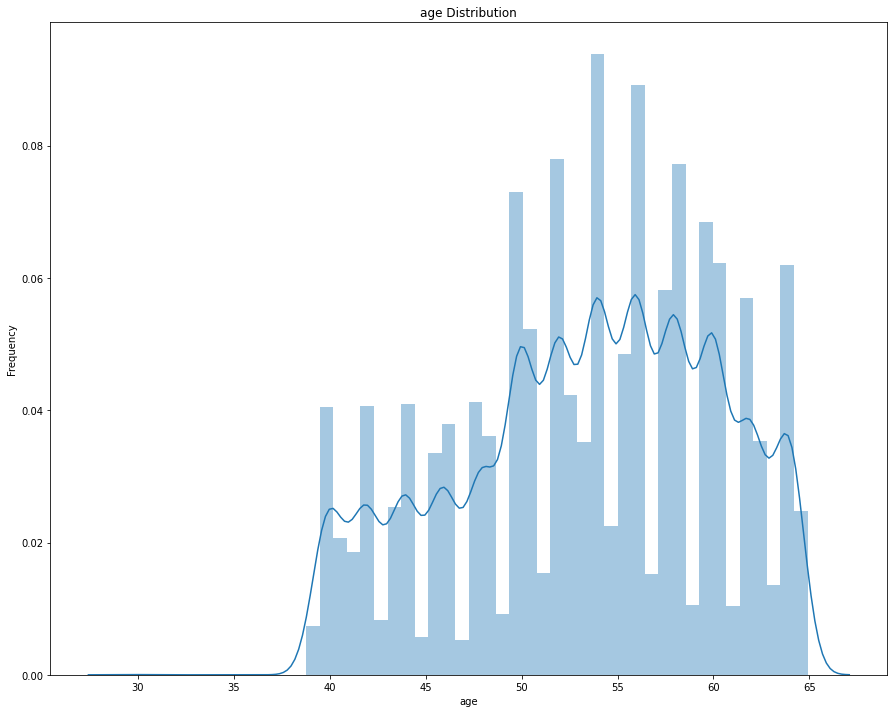

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



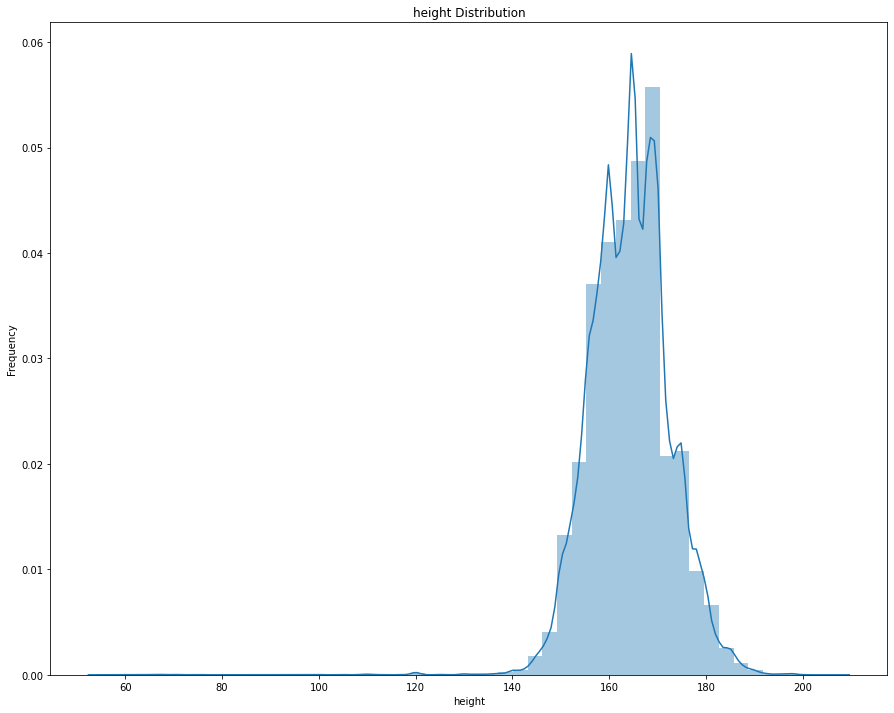

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



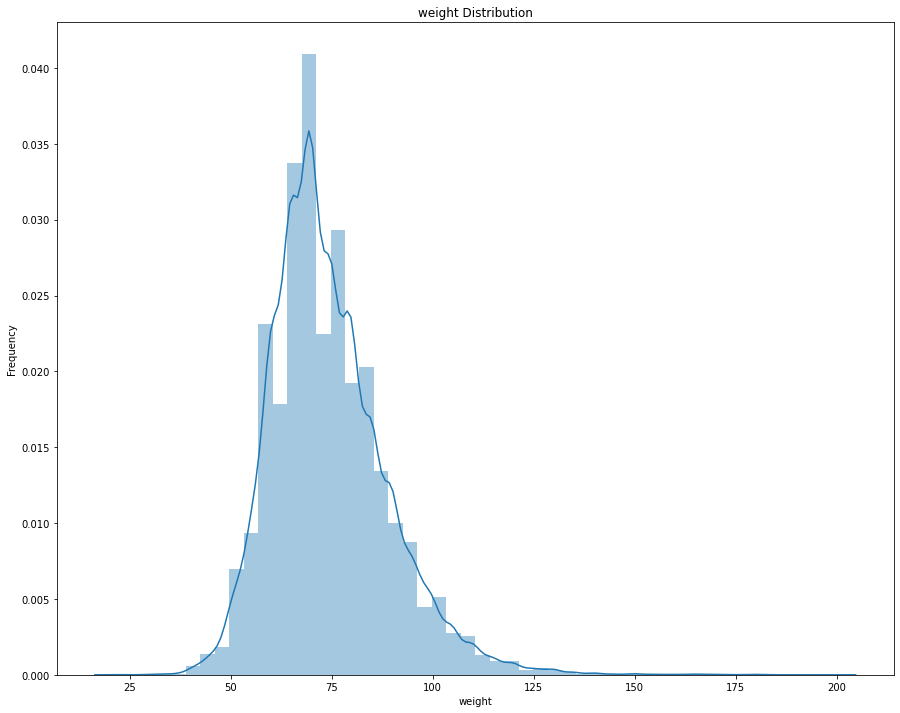

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



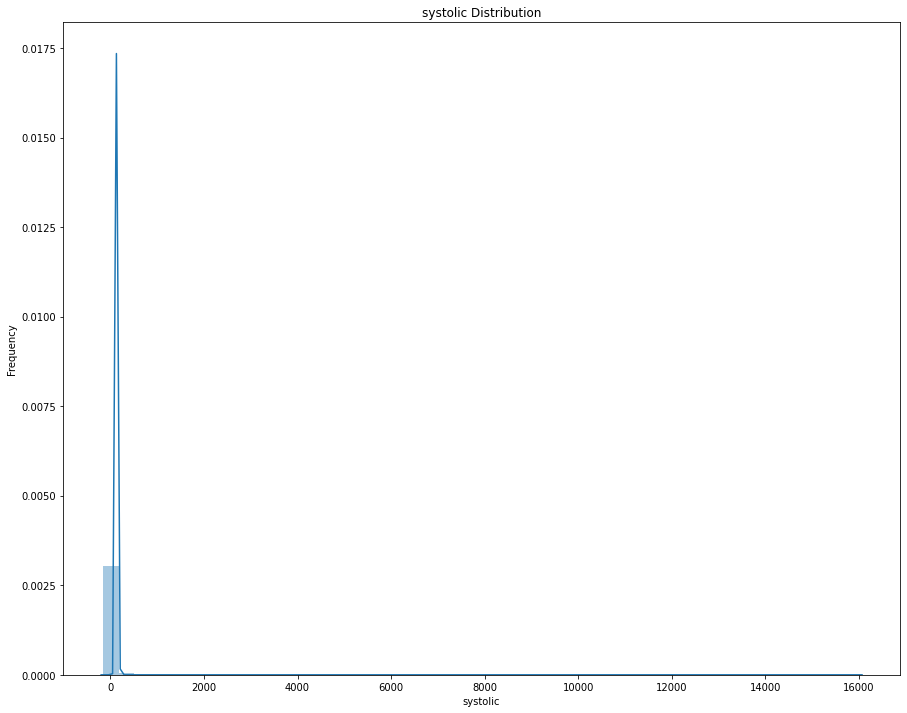

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



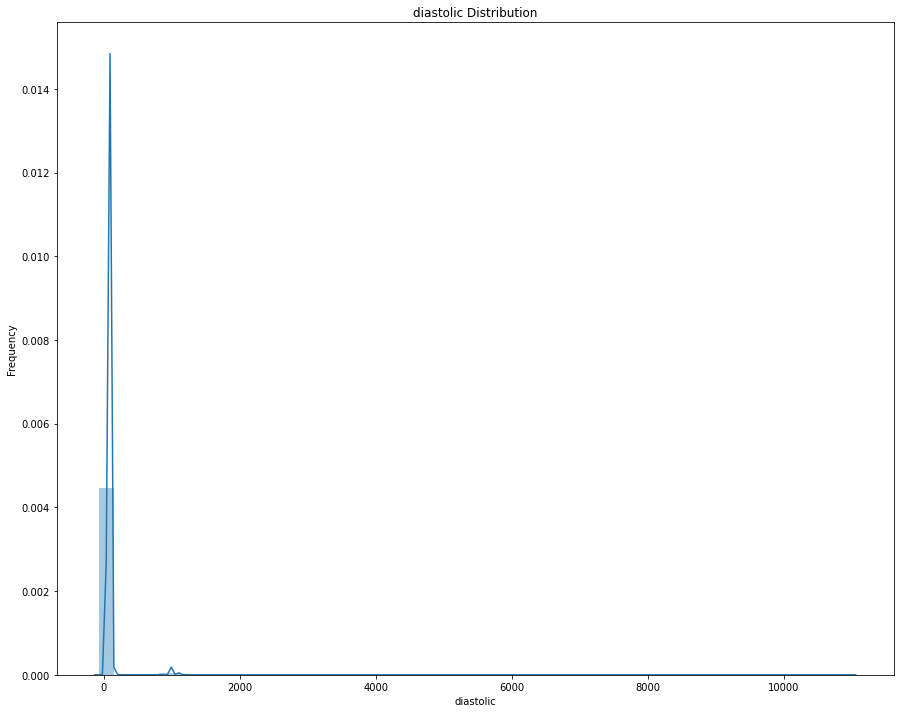

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



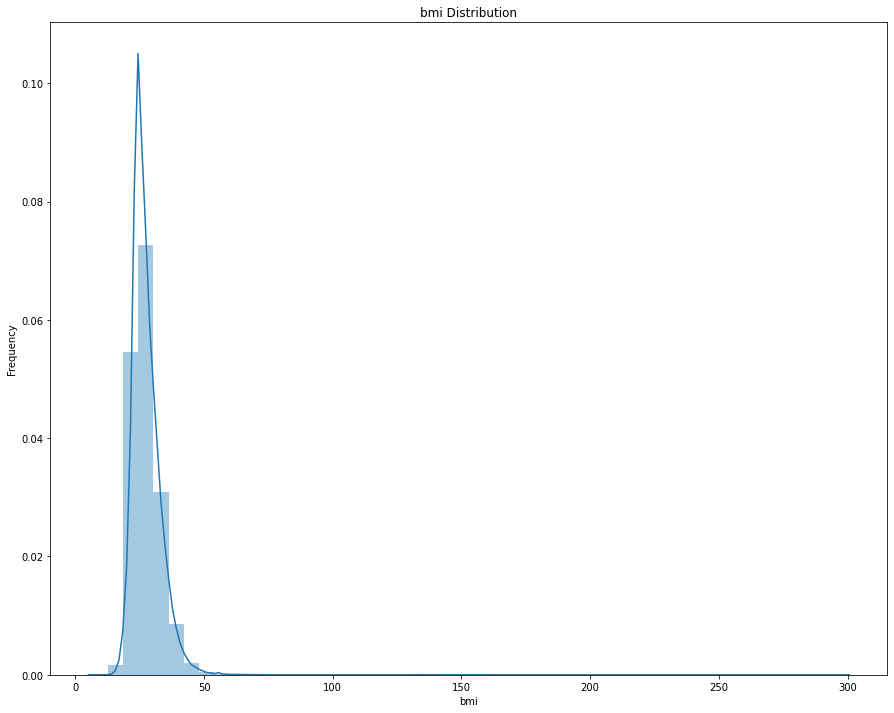

In [ ]:
def distribution_plot(df):
    continuous_vars = []
    
    for col in df.columns:
        if df[col].dtype =='object' or df[col].nunique()>10:
            continuous_vars.append(col)
    
    for var in continuous_vars:
        sns.distplot(df[var])
        plt.title(var+' Distribution')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.show()
        
distribution_plot(df)

# Feature Engineering

* Body Mass Index (BMI) 
* Pulse pressure

In [ ]:
df['pulse pressure'] = df['systolic'] - df['diastolic']

In [ ]:
df.head()

age  gender  height  weight  systolic  diastolic  cholesterol  glucose  \
0  50.4       0     168    62.0       110         80            1        1   
1  55.4       1     156    85.0       140         90            3        1   
2  51.6       1     165    64.0       130         70            3        1   
3  48.2       0     169    82.0       150        100            1        1   
4  47.8       1     156    56.0       100         60            1        1   

   smoke  alcohol  active  cardiovascular disease   bmi  pulse pressure  
0      0        0       1                       0  22.0              30  
1      0        0       1                       1  34.9              50  
2      0        0       0                       1  23.5              60  
3      0        0       1                       1  28.7              50  
4      0        0       0                       0  23.0              40

<Figure size 576x288 with 0 Axes>

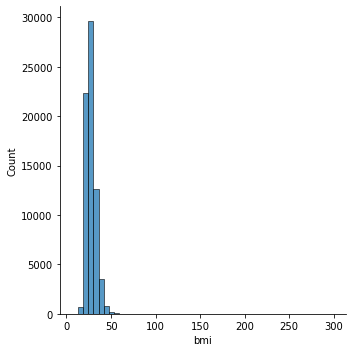

In [ ]:
plt.figure(figsize=(8,4))
sns.displot(df['bmi'], bins=50, kde=False)
plt.show()

# MODEL PREPARATION

1. Split the data into training and testing sets. 
  * The training set is used to train the model, while the testing set is used to evaluate its performance.
2. Train the model on the training set. 
  * Different algorithms have different ways of training the model, but this typically involves finding the parameters that minimize the error on the training set.


In [ ]:
# Set targetted and feature 
X = df.drop(['weight', 'height', 'cardiovascular disease'], axis=1)
y = df['cardiovascular disease']
print(f'Shape of training dataset: {X.shape}')
print(f'Shape of test dataset: {y.shape}')

Shape of training dataset: (69973, 11)
Shape of test dataset: (69973,)


In [ ]:
# Splitting data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Shape of splitting X_train is: {X_train.shape}')
print(f'Shape of splitting X_test is: {X_test.shape}')

Shape of splitting X_train is: (55978, 11)
Shape of splitting X_test is: (13995, 11)


In [ ]:
X.head(5)

age  gender  systolic  diastolic  cholesterol  glucose  smoke  alcohol  \
0  50.4       0       110         80            1        1      0        0   
1  55.4       1       140         90            3        1      0        0   
2  51.6       1       130         70            3        1      0        0   
3  48.2       0       150        100            1        1      0        0   
4  47.8       1       100         60            1        1      0        0   

   active   bmi  pulse pressure  
0       1  22.0              30  
1       1  34.9              50  
2       0  23.5              60  
3       1  28.7              50  
4       0  23.0              40

In [ ]:
y.head(3)

0    0
1    1
2    1
Name: cardiovascular disease, dtype: int64

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69973 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             69973 non-null  float64
 1   gender          69973 non-null  int64  
 2   systolic        69973 non-null  int64  
 3   diastolic       69973 non-null  int64  
 4   cholesterol     69973 non-null  int64  
 5   glucose         69973 non-null  int64  
 6   smoke           69973 non-null  int64  
 7   alcohol         69973 non-null  int64  
 8   active          69973 non-null  int64  
 9   bmi             69973 non-null  float64
 10  pulse pressure  69973 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 6.4 MB


In [ ]:
# Feature scaling
X_scale = StandardScaler()
X_train = X_scale.fit_transform(X_train)
X_test = X_scale.transform(X_test)
print(f'Shape after scaling of X_train is: {X_train.shape}')
print(f'Shape after scaling of X_test is: {X_test.shape}')

Shape after scaling of X_train is: (55978, 11)
Shape after scaling of X_test is: (13995, 11)


## Model algorithms 

* Investigate different classification models and evacuate each to select tge best performer. 

### Comparison table



In [ ]:
# List of models algorthms 
models = [LogisticRegression(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]
result = []

# Iterate through the models
for model in models:
  # Fit the model
  model.fit(X_train, y_train)

  # Predict on the set
  y_pred = model.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Append the results to the list
  result.append([model.__class__.__name__, 
                  accuracy, precision, 
                  recall, f1])

  # # Print the result
  # print(f'{model.__class__.__name__} results:')
  # print(f'Accuracy: {accuracy}')
  # print(f'Precision: {precision}')
  # print(f'Recall: {recall}')
  # print(f'F1-Score: {f1}\n')


# Create a dataframe from the results list
df_results = pd.DataFrame(result, columns=['Model','Accuracy','Precision', 'Recall', 'F1-Score'])

# Print the comparison table
df_results

                    Model  Accuracy  Precision    Recall  F1-Score
0      LogisticRegression  0.718257   0.740849  0.679269  0.708724
1                     SVC  0.728189   0.744008  0.703342  0.723104
2    KNeighborsClassifier  0.677242   0.686447  0.663410  0.674732
3  DecisionTreeClassifier  0.636870   0.642528  0.631974  0.637207
4  RandomForestClassifier  0.697106   0.699280  0.701359  0.700318


In [ ]:
# Create a bar plot
df_results.plot(x='Model', y='Accuracy', kind='bar')

# Add a title and labels
plt.title('Model Accuracy Compariosn')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Show the chart
plt.show()

In [ ]:
# Create a figure with subplots
fig = make_subplots(rows=2, cols=2)

# List of metrics to plot
metrics = ['Accuracy', 'Precision', 'F1-Score', 'Recall']

# Iterate through the metrics
for i, metric in enumerate(metrics):
    # Create a bar plot for each metric
    fig.add_trace(go.Bar(x=df_results['Model'], y=df_results[metric], name=metric),
                  row=i//2+1, col=i%2+1)

# Update the layout
fig.update_layout(title='Model Comparison', xaxis=dict(title='Model'), yaxis=dict(title='Value'))

# Show the plot
fig.show()

## Note

[[7658 2844]<br>
 [3308 7183]]

The matrix you provided is a confusion matrix, which is a table used to define the performance of a classification algorithm. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class. The entries in the matrix are the number of instances that fall in the intersection of predicted and actual class.

In this specific matrix, the format is as follows:

* The first row represents the predicted class as "True", and the second row represents the predicted class as "False"

* The first column represents the actual class as "True", and the second column represents the actual class as "False"

So, in this matrix, the values can be read as:

* 7658 instances were correctly predicted as "True" (True Positive)
* 2844 instances were incorrectly predicted as "True" (False Positive)
* 3308 instances were incorrectly predicted as "False" (False Negative)
* 7183 instances were correctly predicted as "False" (True Negative)

These values are used to calculate various performance metrics such as accuracy, precision, recall, F1-score etc.

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# create an instance of SelectKBest
selector = SelectKBest(score_func=mutual_info_classif, k=1)

# fit the selector to the data
X_new = selector.fit_transform(X, y)

# get the indices of the selected features
selected_features = selector.get_support(indices=True)

# print the selected feature index
selected_features

array([2])

<ipython-input-50-162650294c3e>:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



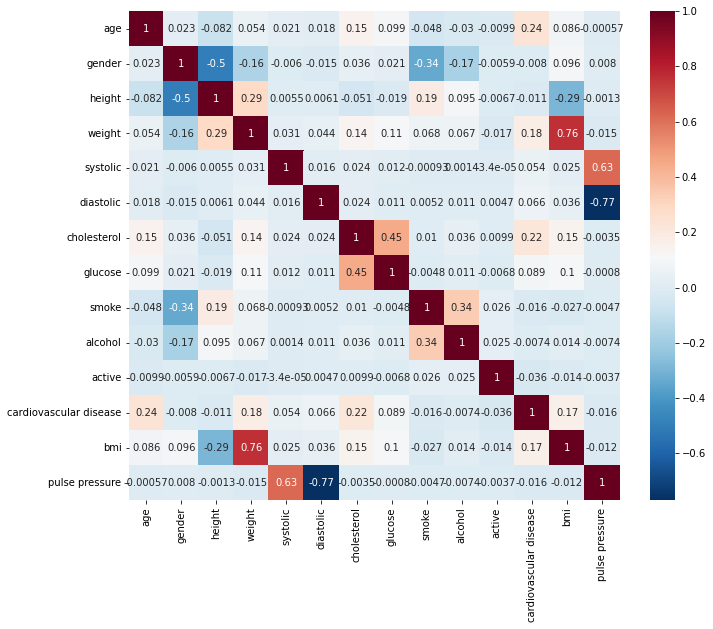

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Create the heatmap
sns.heatmap(corr, annot=True, cmap='RdBu_r')

# Show the plot
plt.show()

# Show the plot
plt.show()

In [ ]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Create heatmap
fig = go.Figure(data=go.Heatmap(
                x=corr_matrix.columns, 
                y=corr_matrix.columns, 
                z=corr_matrix.values,
                colorscale='Viridis'))

# Update layout
fig.update_layout(title='Cardiovascular Disease Correlation Heatmap',
                  xaxis_title='Features',
                  yaxis_title='Features')

# Show the heatmap
fig.show()